In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from imutils import resize
from skimage import data

In [17]:
img = cv.imread("./images/color-wheel.jpg", 0)

## Finding and drawing of contours 

In [44]:
ret, thres = cv.threshold(imgray, 127, 255, 0)
contours, heirarchy = cv.findContours(thres, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
print("Number of contours = " + str(len(contours)))
# print(contours[0])

cont = cv.drawContours(img, contours, -1, (0, 255, 0), 3)

cv.imshow("image", img)
cv.waitKey(0)
cv.destroyAllWindows()

Number of contours = 41


## Shape dectection

In [45]:
_, thres = cv.threshold(imgray, 240, 255, cv.THRESH_BINARY)
contours, _ = cv.findContours(thres, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

for contour in contours:
    """
    @param1: contour
    @param2: Approximation accuracy. This is the maximum distance between the approximation and original curve
    @param3: closed path or not
    arcLength: find contour curved length or parameter
    """
    approx = cv.approxPolyDP(contour, 0.01*cv.arcLength(contour, True), True)
    cv.drawContours(img, [approx], 0, (0, 0, 0), 3)
    
    x, y = approx.ravel()[0] - 1, approx.ravel()[1] - 1
    
    if len(approx) == 3: cv.putText(img, "Triangle", (x, y), cv.FONT_HERSHEY_COMPLEX, 0.5, (0,0,0))
    elif len(approx) == 4:
        x1, y1, w, h =  cv.boundingRect(approx)
        aspectRatio = float(w)/h
        
        if aspectRatio >= 0.9 and aspectRatio <= 1.05: cv.putText(img, "Sqaure", (x, y), cv.FONT_HERSHEY_COMPLEX, 0.5, (0,0,0))
        else: cv.putText(img, "Rectangle", (x, y), cv.FONT_HERSHEY_COMPLEX, 0.5, (0,0,0))
    elif len(approx) == 5: cv.putText(img, "Pentagon", (x, y), cv.FONT_HERSHEY_COMPLEX, 0.5, (0,0,0))
    elif len(approx) == 10: cv.putText(img, "Star", (x, y), cv.FONT_HERSHEY_COMPLEX, 0.5, (0,0,0))
    else: cv.putText(img, "Circle", (x, y), cv.FONT_HERSHEY_COMPLEX, 0.5, (0,0,0))
        
cv.imshow("image", img)
cv.waitKey(0)
cv.destroyAllWindows()

## Shi tomashi method to find corners

In [14]:
"""
@param1: image : prefered grayscale
@param2: number of corner to be found
@param3: minimal quality level of the detect corner
@param4: minimum distance
"""
corners = cv.goodFeaturesToTrack(imgray, 100, 0.01, 10)
corners = np.int0(corners)

for corner in corners:
    x, y = corner.ravel()
    cv.circle(img, (x, y), 5, (0, 255, 0), -1)

cv.imshow("img", img)
cv.waitKey(0)
cv.destroyAllWindows()

## Harris corner dectection
* Determine which window produces very large variation in the pixel intensity moved in both x and y direction
* With which such window is found, a score R is calculated
* after applying a threshold to this score, important corner are selected

In [15]:
"""
@param1: image itself, should be float32 type
@param2: block size
@param3: ksize aperture parameter of sobel derivative used
@param4: Harris dectecter free parameter in the equation
"""

imgray = np.float32(imgray)
dst = cv.cornerHarris(imgray, 2, 3, 0.04)

dst = cv.dilate(dst, None)
img[dst > 0.01 * dst.max()] = [0, 0, 255]

cv.imshow("dst", img)
cv.waitKey(0)
cv.destroyAllWindows()

# Morphological transformation
* These are the simple image operation based on the image shape

In [66]:
"""Helper function to display all images"""

def showAll(*images, title=[]):
    length = len(images)
    if len(title) == 0:
        title = [i for i in range(length)]
    assert len(title) == length, "Length of the all the images should be equal to title"
    
    nrows = length // 4 if length % 4 == 0 else length // 4 + 1 
    ncols = 4 if length > 4 else length
    
    _, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 10*nrows))
    for ax, img, cap in zip(axes.ravel(), images, title):
        ax.imshow(img, cmap="gray")
        ax.set_title(cap)
plt.show()

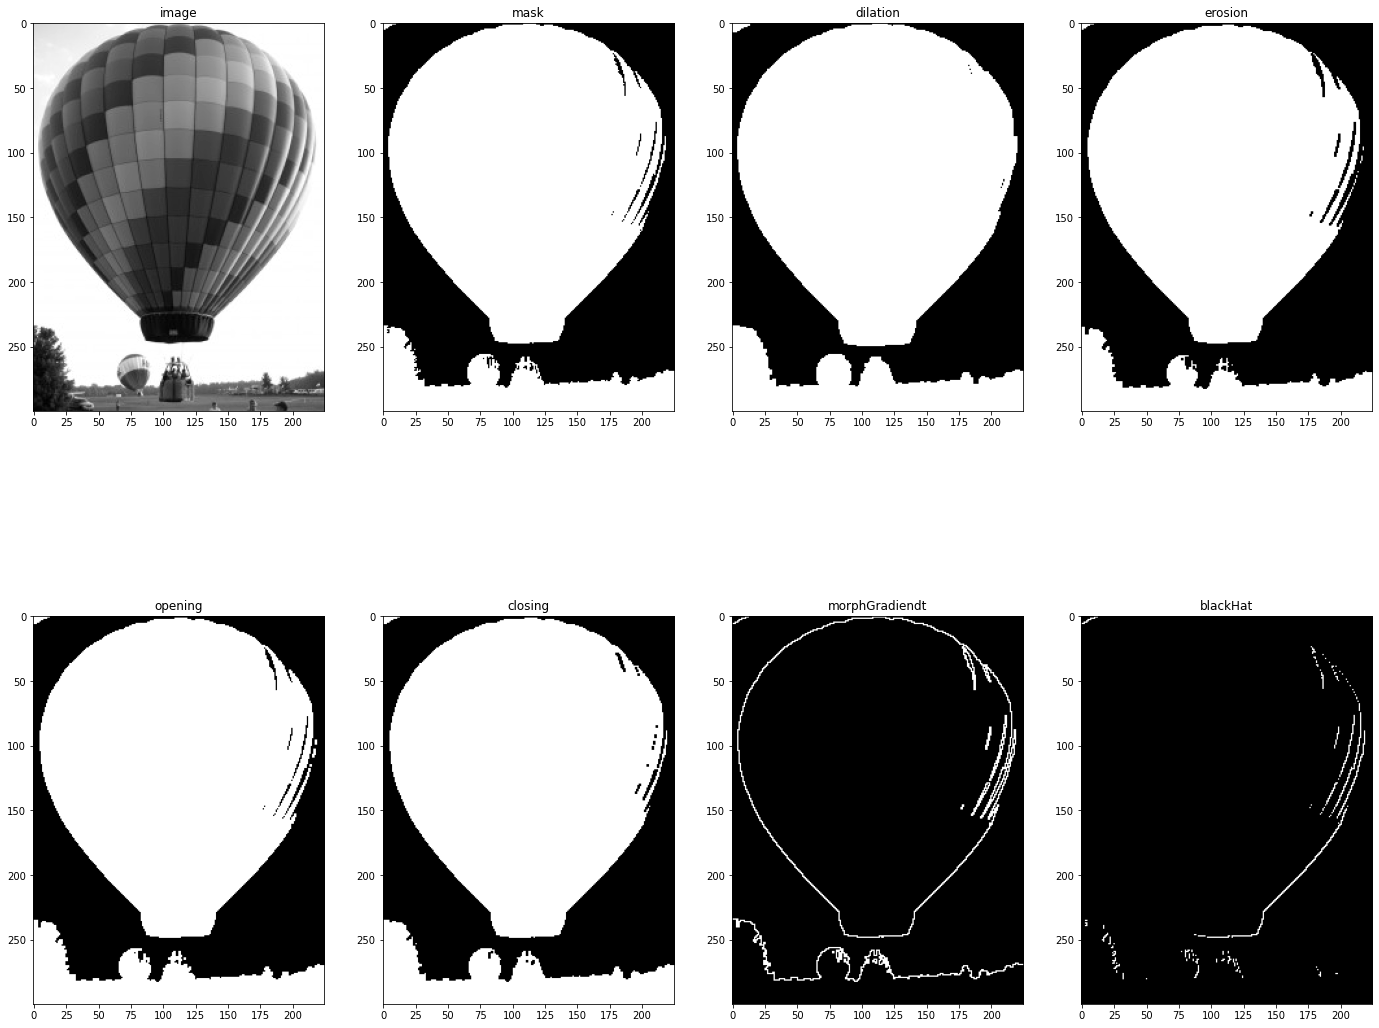

In [67]:
_, mask = cv.threshold(img, 220, 255, cv.THRESH_BINARY_INV)
kernel = np.ones((2, 2), np.uint8)

dilation = cv.dilate(mask, kernel, iterations=2)
erosion = cv.erode(mask, kernel, iterations=1)
opening = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
closing = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
morphGradiendt = cv.morphologyEx(mask, cv.MORPH_GRADIENT, kernel)
blackHat = cv.morphologyEx(mask, cv.MORPH_BLACKHAT, kernel)

showAll(img, mask, dilation, erosion, opening, closing, morphGradiendt, blackHat, title=["image", "mask", "dilation", "erosion", "opening", "closing", "morphGradiendt", "blackHat"])

## Hough Transform
* This technique is use to detect any shape if the shape can be reprsented in mathematical form<br></br>
#### Hough transform algorithm
1. Edge detection
2. Mapping of edge points to the hough space and storage in an accumulator
3. Interpretation of accumulator to yield lines of infinite length. The interpretation os done by thresholding and possibly other constraints.
4. Converstion of infinite line to finite lines.

In [37]:
#Houghline transform

image = cv.imread("./images/color-wheel.jpg")
img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

"""
@param2: threshold 1 for hysteresis
@param3: threshold 2 for hysteresis
@param4: aperture size for the Sobel operator
"""
edges = cv.Canny(img, 50, 150, apertureSize=3)
cv.imshow("edges", edges)

"""
@param1: binary image source
@param2: distance resolution of accumulator in pixel
@param3: angle resolution of accumulator in radians
@param4: threshold of the accumulator
"""
lines = cv.HoughLines(edges, 1, np.pi / 180, 200)

for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * a)
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * a)
    cv.line(image, (x1, y1), (x2, y2), (0, 255), 30)

cv.imshow("image", image)
cv.waitKey(0)
cv.destroyAllWindows()

In [42]:
# Probabilistic Hough line
# image = cv.imread("./images/snakes.png")
img = data.checkerboard()
# img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

edges = cv.Canny(img, 50, 150, apertureSize=3)
cv.imshow("edges", edges)

lines = cv.HoughLinesP(edges, 1, np.pi/180, 50, minLineLength=20, maxLineGap=2)
for line in lines:
    x1,x2,y1,y2 = line[0]
    cv.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

cv.imshow("image", image)
cv.waitKey(0)
cv.destroyAllWindows()

#Not working even with the simple images

In [54]:
img = cv.imread("images/color-wheel.jpg")
output = img.copy()
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = cv.medianBlur(gray, 5)

circle = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1,
                         20, param1=50, param2=30,
                         minRadius=0, maxRadius=500)
detected_circle = np.uint16(np.around(circle))
for (x, y, r) in detected_circle[0, ]:
    cv.circle(output, (x, y), r, (0, 0, 0), 3)
    cv.circle(output, (x, y), 2, (0, 0, 0), 3)

cv.imshow("output", output)
cv.waitKey(0)
cv.destroyAllWindows()